# 3D Medical Imaging Processing Tutorial

This notebook demonstrates how to use the Imaging_3D modules in the medical project to process 3D medical images with quality control, preprocessing, and segmentation capabilities.

## Overview

The Imaging_3D module provides functionality for:
1. **Image Quality Control**: Automated quality assessment for 3D medical images
2. **Mask Quality Control**: Quality assessment and validation for segmentation masks
3. **3D Image Preprocessing**: Standardization and preprocessing of 3D medical images
4. **TotalSegmentator Integration**: Advanced anatomical segmentation using TotalSegmentator

## Table of Contents
1. [Setup and Environment Check]()
2. [Run default test]()

## 1. Setup and Environment Check

In [3]:
# Check if the Imaging_3D modules exist and are accessible
import os
import sys
import torch
import warnings
import numpy as np
import torchio as tio
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Get the current notebook directory
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent  # Assuming notebook is in tutorial/
imaging_3d_path = project_root / "medicalproject2024" / "preprocess" / "Imaging_3D"

print(f"Notebook directory: {notebook_dir}")
print(f"Project root: {project_root}")
print(f"Imaging_3D path: {imaging_3d_path}")
print(f"Imaging_3D path exists: {imaging_3d_path.exists()}")

if imaging_3d_path.exists():
    print("Imaging_3D modules found!")
    
    # Check available modules
    modules = {
        "preprocessing/": imaging_3d_path / "preprocessing",
        "quality_control/image/": imaging_3d_path / "quality_control" / "image",
        "quality_control/mask/": imaging_3d_path / "quality_control" / "mask",
        "TotalSegmentator inference": imaging_3d_path / "quality_control" / "mask" / "inference_TotalSegmentator.py",
        "Test LiTS": imaging_3d_path / "quality_control" / "mask" / "test_lits.py",
        "Dataset module": imaging_3d_path / "quality_control" / "mask" / "dataset.py",
        "Model module": imaging_3d_path / "quality_control" / "mask" / "model.py"
    }
    
    print("\nAvailable modules:")
    for module_name, module_path in modules.items():
        status = "Exists" if module_path.exists() else "Not Exists"
        print(f"  {status} {module_name}")
        
else:
    print("Imaging_3D modules not found!")
    print("Please ensure the modules are in the correct directory.")

# Add project root to Python path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"\nPython path updated with: {project_root}")

Notebook directory: /home/tjl20001104/workspace/Projects/USC/biobank/hugging-health/medicalproject2024/tutorial
Project root: /home/tjl20001104/workspace/Projects/USC/biobank/hugging-health
Imaging_3D path: /home/tjl20001104/workspace/Projects/USC/biobank/hugging-health/medicalproject2024/preprocess/Imaging_3D
Imaging_3D path exists: True
Imaging_3D modules found!

Available modules:
  Exists preprocessing/
  Exists quality_control/image/
  Exists quality_control/mask/
  Exists TotalSegmentator inference
  Exists Test LiTS
  Exists Dataset module
  Exists Model module

Python path updated with: /home/tjl20001104/workspace/Projects/USC/biobank/hugging-health


In [2]:
# Test importing Imaging_3D modules
def test_imports():
    """Test importing Imaging_3D modules"""
    import_results = {}
    
    # Test basic imports
    modules_to_test = [
        ("medicalproject2024.preprocess.Imaging_3D.quality_control.mask.dataset", "Mask Dataset"),
        ("medicalproject2024.preprocess.Imaging_3D.quality_control.mask.model", "Mask Model"),
        ("medicalproject2024.preprocess.Imaging_3D.quality_control.mask.test_lits", "LiTS Test"),
        ("medicalproject2024.preprocess.Imaging_3D.quality_control.mask.inference_TotalSegmentator", "TotalSegmentator"),
    ]
    
    for module_path, module_name in modules_to_test:
        try:
            __import__(module_path)
            import_results[module_name] = "Success"
        except ImportError as e:
            import_results[module_name] = f"Failed: {str(e)}..."
        except Exception as e:
            import_results[module_name] = f"Warning: {str(e)}..."
    
    print("Import Test Results:")
    print("-" * 50)
    for module_name, result in import_results.items():
        print(f"{module_name:20}: {result}")
    
    return import_results

# Run import tests
import_results = test_imports()

Import Test Results:
--------------------------------------------------
Mask Dataset        : Success
Mask Model          : Success
LiTS Test           : Success
TotalSegmentator    : Success


In [3]:
# Check for additional dependencies
def check_dependencies():
    """Check for required dependencies for 3D imaging"""
    dependencies = {
        "torch": "PyTorch for deep learning",
        "torchvision": "PyTorch vision utilities",
        "nibabel": "Neuroimaging data I/O",
        "SimpleITK": "Medical image processing",
        "matplotlib": "Plotting and visualization",
        "pandas": "Data manipulation",
        "numpy": "Numerical computing",
        "tqdm": "Progress bars"
    }
    
    print("Dependency Check:")
    print("-" * 50)
    
    missing_deps = []
    for dep, description in dependencies.items():
        try:
            __import__(dep)
            print(f"{dep:15}: {description}")
        except ImportError:
            print(f"{dep:15}: {description} (MISSING)")
            missing_deps.append(dep)
    
    if missing_deps:
        print(f"\nMissing dependencies: {missing_deps}")
        print("Install with: pip install " + " ".join(missing_deps))
    else:
        print("\nAll dependencies available!")
    
    return len(missing_deps) == 0

# Check dependencies
deps_available = check_dependencies()

Dependency Check:
--------------------------------------------------
torch          : PyTorch for deep learning
torchvision    : PyTorch vision utilities
nibabel        : Neuroimaging data I/O
SimpleITK      : Medical image processing
matplotlib     : Plotting and visualization
pandas         : Data manipulation
numpy          : Numerical computing
tqdm           : Progress bars

All dependencies available!


## 2. Run Default Lits Test

Run Default Lits to test whether code works

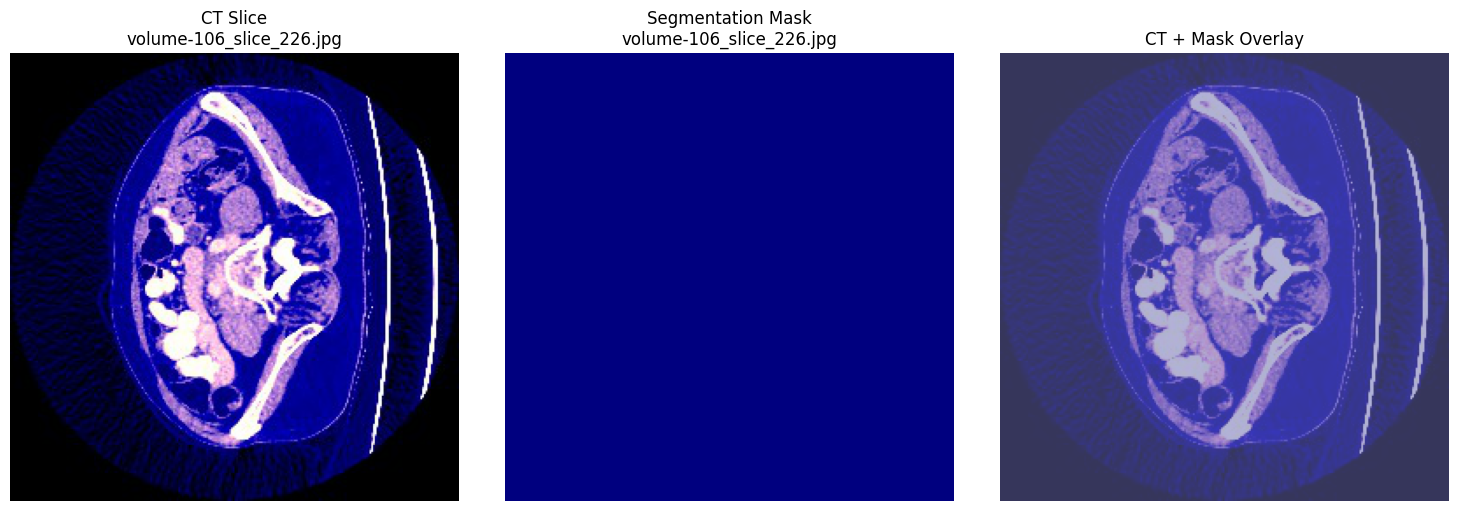


Image Information:
CT Image Shape: (256, 256, 3)
CT Value Range: 0 - 255
Mask Shape: (256, 256)
Mask Value Range: 0 - 0
Unique mask values: [0]

Segmentation Statistics:
Total pixels: 65,536
Liver pixels: 0
Liver coverage: 0.00%


In [6]:
def visualize_lits_sample():
    """Visualize a sample LiTS CT slice and its corresponding mask"""
    
    # Check if LiTS data exists
    data_dir = Path("./data/LiTS")
    train_images_dir = data_dir / "train_images" / "train_images"
    train_masks_dir = data_dir / "train_masks" / "train_masks"
    
    if not train_images_dir.exists() or not train_masks_dir.exists():
        print("LiTS data not found. Please run the default test first to download the data.")
        return
    
    # Get a sample image and mask
    image_files = list(train_images_dir.glob("*.jpg"))
    if not image_files:
        print("No image files found in LiTS directory.")
        return
    
    # Take the first image as sample
    sample_image_path = image_files[0]
    sample_mask_path = train_masks_dir / sample_image_path.name
    
    if not sample_mask_path.exists():
        print(f"Corresponding mask not found for {sample_image_path.name}")
        return
    
    # Load and display the images
    try:
        # Load CT image
        ct_image = Image.open(sample_image_path)
        ct_array = np.array(ct_image)
        
        # Load segmentation mask
        mask_image = Image.open(sample_mask_path)
        mask_array = np.array(mask_image)
        
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original CT slice
        axes[0].imshow(ct_array, cmap='gray')
        axes[0].set_title(f'CT Slice\n{sample_image_path.name}', fontsize=12)
        axes[0].axis('off')
        
        # Segmentation mask
        axes[1].imshow(mask_array, cmap='jet')
        axes[1].set_title(f'Segmentation Mask\n{sample_mask_path.name}', fontsize=12)
        axes[1].axis('off')
        
        # Overlay
        axes[2].imshow(ct_array, cmap='gray', alpha=0.7)
        axes[2].imshow(mask_array, cmap='jet', alpha=0.3)
        axes[2].set_title('CT + Mask Overlay', fontsize=12)
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print image information
        print(f"\nImage Information:")
        print(f"CT Image Shape: {ct_array.shape}")
        print(f"CT Value Range: {ct_array.min()} - {ct_array.max()}")
        print(f"Mask Shape: {mask_array.shape}")
        print(f"Mask Value Range: {mask_array.min()} - {mask_array.max()}")
        print(f"Unique mask values: {np.unique(mask_array)}")
        
        # Calculate basic statistics
        liver_pixels = np.sum(mask_array > 0)
        total_pixels = mask_array.size
        liver_percentage = (liver_pixels / total_pixels) * 100
        
        print(f"\nSegmentation Statistics:")
        print(f"Total pixels: {total_pixels:,}")
        print(f"Liver pixels: {liver_pixels:,}")
        print(f"Liver coverage: {liver_percentage:.2f}%")
        
    except Exception as e:
        print(f"Error loading images: {e}")

# Try to visualize sample data
visualize_lits_sample()

TorchIO successfully imported
TorchIO Transform Demonstration
Original image shape: torch.Size([3, 256, 256, 1])
Image value range: 0.0 - 255.0


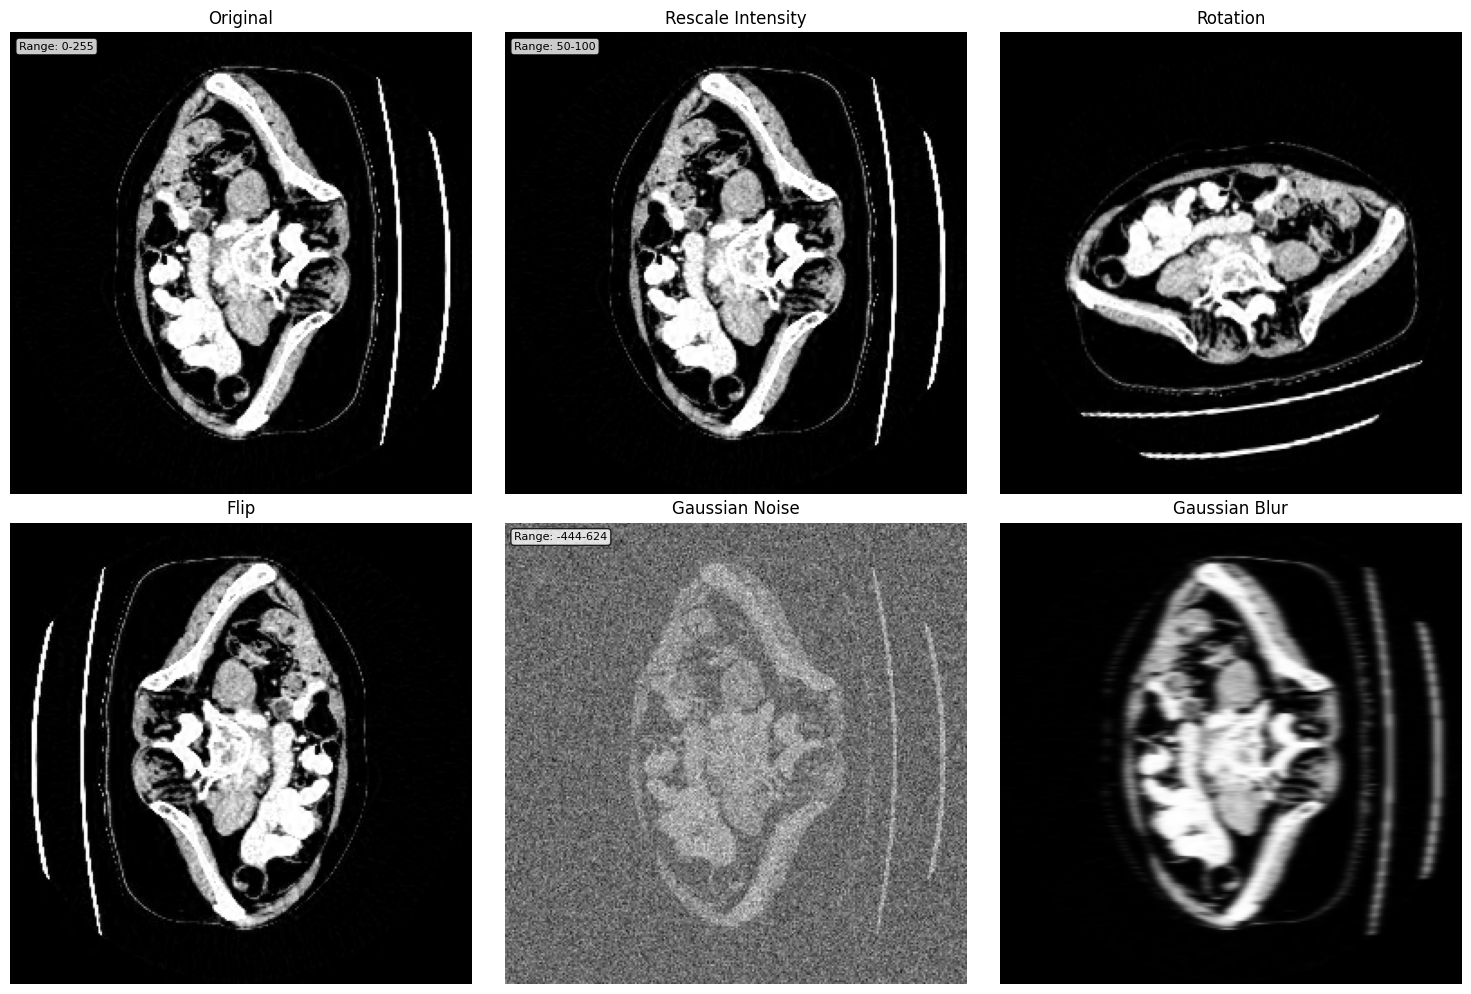


Transform Composition Example:


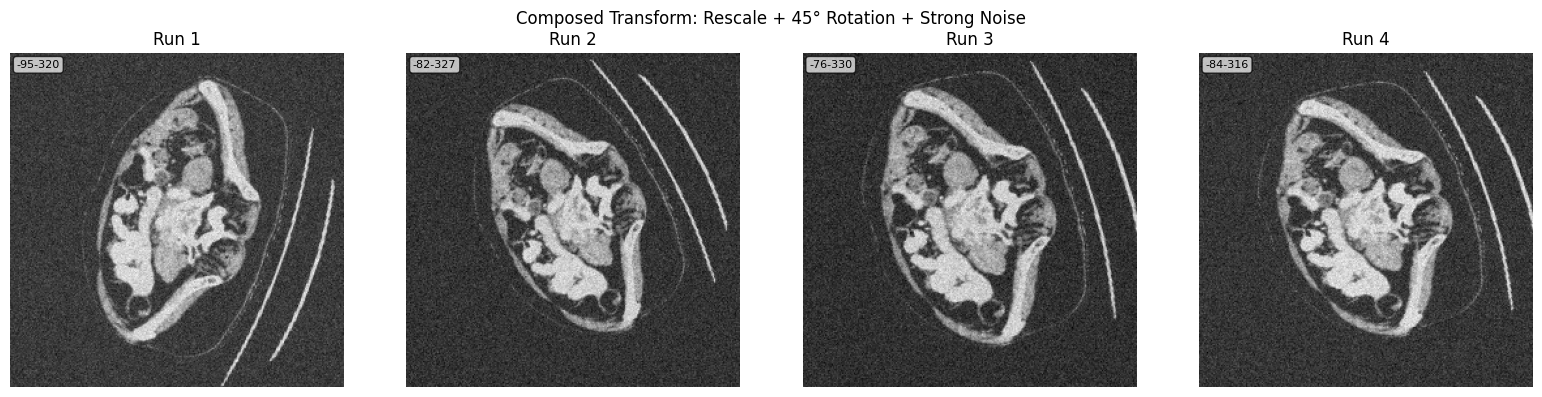

In [18]:
def demonstrate_torchio_transforms():
    """Demonstrate TorchIO transforms with visualization"""
    
    # First check if torchio is available
    try:
        import torchio as tio
        print("TorchIO successfully imported")
    except ImportError:
        print("TorchIO not found. Please install...")
        return
    
    # Check if LiTS data exists
    data_dir = Path("./data/LiTS")
    train_images_dir = data_dir / "train_images" / "train_images"
    
    if not train_images_dir.exists():
        print("LiTS data not found. Please run the LiTS test first.")
        return
    
    # Load sample image
    image_files = list(train_images_dir.glob("*.jpg"))
    if not image_files:
        print("No image files found.")
        return
    
    sample_image_path = image_files[0]
    
    try:
        # Prepare image for TorchIO
        pil_image = Image.open(sample_image_path)
        image_array = np.array(pil_image)
        
        # Convert to 4D tensor (C, H, W, D)
        if len(image_array.shape) == 2:
            image_array = np.stack([image_array] * 3, axis=-1)
        
        tensor_4d = torch.tensor(image_array).permute(2, 0, 1).unsqueeze(-1).float()
        
        # Create TorchIO subject
        subject = tio.Subject(
            image=tio.ScalarImage(tensor=tensor_4d),
        )
        
        print("TorchIO Transform Demonstration")
        print(f"Original image shape: {tensor_4d.shape}")
        print(f"Image value range: {tensor_4d.min():.1f} - {tensor_4d.max():.1f}")
        
        # Define transforms with enhanced effects
        transforms = {
            'Original': None,
            'Rescale Intensity': tio.RescaleIntensity(out_min_max=(50, 100)),  # More dramatic rescaling
            'Rotation': tio.RandomAffine(degrees=90, p=1.0),  # Fixed 90 degree rotation
            'Flip': tio.Flip(axes=(1,)),  # Left-right flip
            'Gaussian Noise': tio.RandomNoise(std=100),  # Much stronger noise
            'Gaussian Blur': tio.RandomBlur(std=3.0),  # Stronger blur
        }
        
        # Create visualization
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        for idx, (transform_name, transform_func) in enumerate(transforms.items()):
            ax = axes[idx]
            
            try:
                if transform_func is None:
                    # Original image
                    display_image = subject.image.data[0, :, :, 0].numpy()
                else:
                    # Apply transform
                    transformed_subject = transform_func(subject)
                    display_image = transformed_subject.image.data[0, :, :, 0].numpy()
                
                # Display image
                im = ax.imshow(display_image, cmap='gray')
                ax.set_title(transform_name)
                ax.axis('off')
                
                # Add value range info for intensity transforms
                if transform_name in ['Original', 'Rescale Intensity', 'Gaussian Noise']:
                    ax.text(0.02, 0.98, f'Range: {display_image.min():.0f}-{display_image.max():.0f}', 
                           transform=ax.transAxes, fontsize=8, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
            except Exception as e:
                print(f"Failed to apply {transform_name}: {str(e)[:30]}...")
                # Show original if transform fails
                display_image = subject.image.data[0, :, :, 0].numpy()
                ax.imshow(display_image, cmap='gray')
                ax.set_title(f'{transform_name} (Failed)')
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Demonstrate transform composition with enhanced effects
        print("\nTransform Composition Example:")
        
        # Create composed transform with stronger effects
        composed_transform = tio.Compose([
            tio.RescaleIntensity(out_min_max=(0, 255)),  # Full range rescaling
            tio.RandomAffine(degrees=45, p=1.0),  # 45 degree rotation
            tio.RandomNoise(std=20)  # Stronger noise
        ])
        
        # Apply composed transform multiple times
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        
        for i in range(4):
            transformed_subject = composed_transform(subject)
            display_image = transformed_subject.image.data[0, :, :, 0].numpy()
            
            axes[i].imshow(display_image, cmap='gray')
            axes[i].set_title(f'Run {i+1}')
            axes[i].axis('off')
            
            # Add range info
            axes[i].text(0.02, 0.98, f'{display_image.min():.0f}-{display_image.max():.0f}', 
                        transform=axes[i].transAxes, fontsize=8, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        plt.suptitle('Composed Transform: Rescale + 45° Rotation + Strong Noise')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error in demonstration: {e}")

# Run the demonstration
demonstrate_torchio_transforms()

In [8]:
# Run default LiTS test
!python Imaging_3D.py

Script directory: /home/tjl20001104/workspace/Projects/USC/biobank/hugging-health/medicalproject2024/tutorial
Project root: /home/tjl20001104/workspace/Projects/USC/biobank/hugging-health
Python path updated with: /home/tjl20001104/workspace/Projects/USC/biobank/hugging-health

 3D Medical Imaging Processing Tutorial
Dependency Check:
--------------------------------------------------
torch          : PyTorch for deep learning
torchvision    : PyTorch vision utilities
nibabel        : Neuroimaging data I/O
SimpleITK      : Medical image processing
matplotlib     : Plotting and visualization
2025-10-29 18:49:58,559 - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
2025-10-29 18:49:58,559 - INFO - NumExpr defaulting to 16 threads.
pandas         : Data manipulation
numpy          : Numerical computing
tqdm           : Progress bars
pickle         : Data serialization

All dependencies available!

Importing Imaging_3D Modules:
-----